# Analysis of Job Market

In [75]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from geopy.geocoders import Nominatim
import folium
import time

In [76]:
df = pd.read_csv("/mnt/d/pyTensor/tf217/processed_DataSet.csv")
df.head()

,jobTitle,company,location,jobLink,skills,experience_min,experience_max,min_salary,max_salary
0,Data Analyst,Version 1,Bengaluru,https://www.naukri.com/job-listings-data-analy...,"Computer science, Data analysis, Analytical, A...",0,3,NaN,NaN
1,Data Analyst,Wolters Kluwer - Medknow Publications,"Kalyani, Pune",https://www.naukri.com/job-listings-data-analy...,"Computer science, Backend, Data analysis, Data...",3,5,NaN,NaN
2,Data Analyst,Indegene,Bengaluru,https://www.naukri.com/job-listings-data-analy...,"Automation, Data analysis, Business analytics,...",0,4,NaN,NaN
3,Data Analyst,Klene Paks,Bengaluru(Bannerghatta Road),https://www.naukri.com/job-listings-data-analy...,"HLOOKUP, Pivot Table, VLOOKUP, Excel Macros, D...",3,8,3.75,6.0
4,Team Member Data Analyst,Bajaj Allianz General Insurance,Pune,https://www.naukri.com/job-listings-team-membe...,"Automation, Data validation, Process efficienc...",0,4,NaN,NaN


## Experience vs Salary

/tmp/ipykernel_922/2814320224.py:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x=(df['experience_min'] + df['experience_max']) / 2,


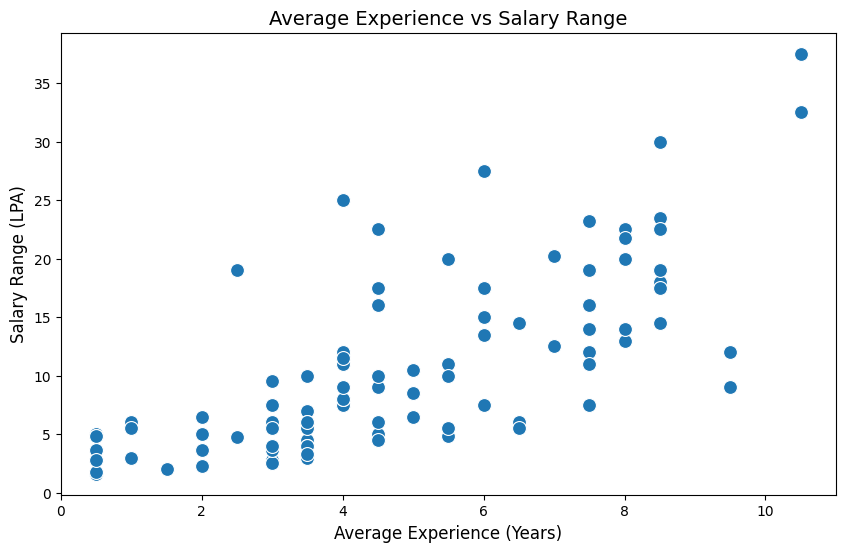

In [77]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=(df['experience_min'] + df['experience_max']) / 2,
                y=(df['min_salary'] + df['max_salary']) / 2,
                palette="Set2",
                s=100,
                marker='o')

plt.xlabel('Average Experience (Years)', fontsize=12)
plt.ylabel('Salary Range (LPA)', fontsize=12)
plt.title('Average Experience vs Salary Range', fontsize=14)

plt.show()

## Location vs Salary

In [78]:
data_expanded = df.assign(location=df['location'].str.split(',')).explode('location')
data_expanded['location'] = data_expanded['location'].str.strip()

In [79]:
data_expanded['avg_salary'] = data_expanded[['min_salary' , 'max_salary']].mean(axis=1)
location_salary = data_expanded.groupby('location')['avg_salary'].mean().dropna()

/tmp/ipykernel_922/2987694830.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


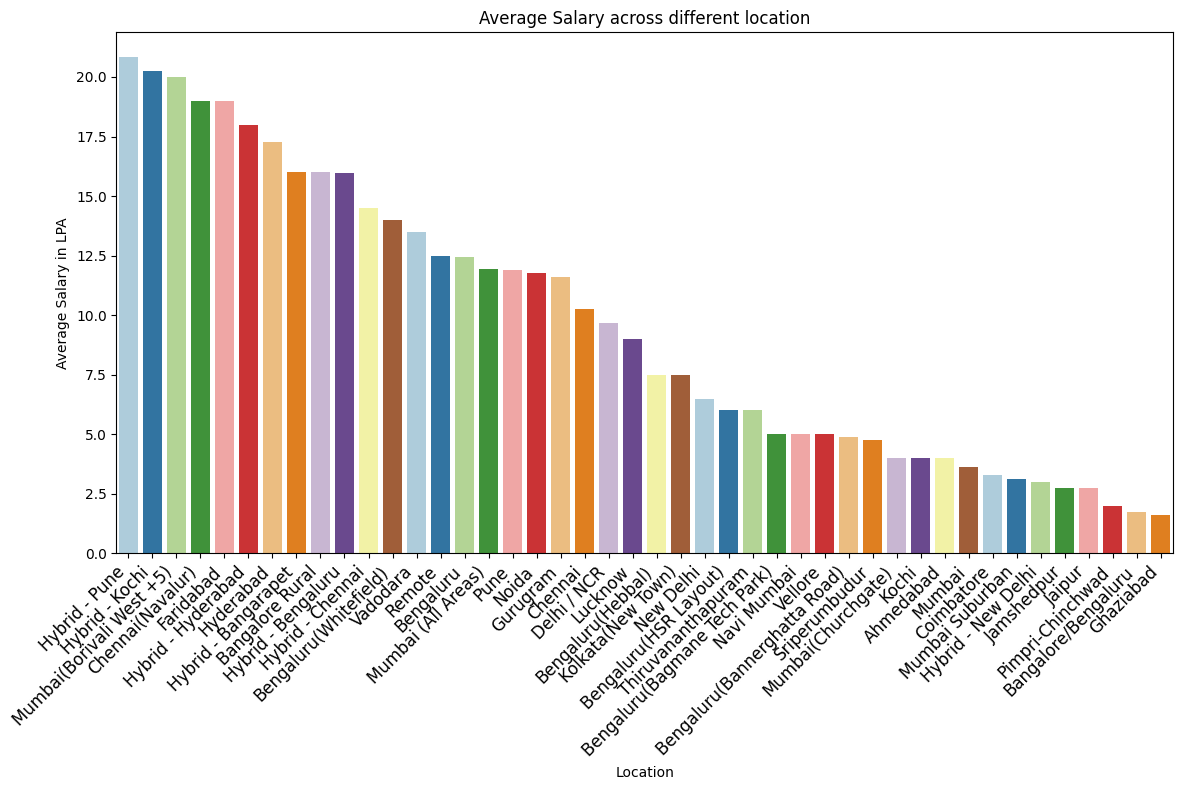

In [80]:
location_salary_df = location_salary.reset_index()
location_salary_df = location_salary_df.sort_values(by='avg_salary', ascending=False)
plt.figure(figsize=(12,8))
sns.barplot(
        x='location',
        y='avg_salary',
        data=location_salary_df,
        palette='Paired'
)

plt.xlabel("Location")
plt.ylabel("Average Salary in LPA")
plt.title("Average Salary across different location")
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.tight_layout()
plt.show()

# Representing Location and Salary Graph on india map

In [81]:
file_path = '/mnt/d/pyTensor/tf217/processed_DataSet.csv'
dataset = pd.read_csv(file_path)

dataset['cleaned_location'] = dataset['location'].str.split('(').str[0].str.strip()

dataset['avg_salary'] = dataset[['min_salary', 'max_salary']].mean(axis=1)

geolocator = Nominatim(user_agent="location_mapper")

def geocode_location(location):
    try:
        location_data = geolocator.geocode(location, timeout=10)
        if location_data:
            return location_data.latitude, location_data.longitude
    except Exception as e:
        print(f"Error geocoding {location}: {e}")
    return None, None  

unique_locations = dataset['cleaned_location'].unique()
location_coords = {}

for location in unique_locations:
    if location not in location_coords:
        lat, lon = geocode_location(location)
        if lat and lon:
            location_coords[location] = (lat, lon)
        else:
            location_coords[location] = (None, None)
        time.sleep(1)


location_coords_df = pd.DataFrame.from_dict(location_coords, orient='index', columns=['latitude', 'longitude'])
location_coords_df.reset_index(inplace=True)
location_coords_df.rename(columns={'index': 'cleaned_location'}, inplace=True)

dataset = dataset.merge(location_coords_df, on='cleaned_location', how='left')

dataset = dataset.dropna(subset=['latitude', 'longitude'])

location_salary = dataset.groupby(['cleaned_location', 'latitude', 'longitude'])['avg_salary'].mean().reset_index()

m = folium.Map(location=[20.5937, 78.9629], zoom_start=5)

for _, row in location_salary.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=row['avg_salary'] / 2 if row['avg_salary'] else 5,
        popup=f"City: {row['cleaned_location']}<br>Avg Salary: {row['avg_salary']:.2f} LPA",
        color='blue',
        fill=True,
        fill_opacity=0.6
    ).add_to(m)

map_path = "location_vs_salary_map_india.html"
m.save(map_path)
print(f"Map saved as '{map_path}'. Open this file in your browser to view.")

Map saved as 'location_vs_salary_map_india.html'. Open this file in your browser to view.


# Job Industry and experience

In [82]:
def extract_industry(job_title):
    job_title = job_title.lower()
    if 'data analyst' in job_title:
        return 'Data Analyst'
    elif 'frontend' in job_title:
        return 'Frontend Development'
    elif 'backend' in job_title:
        return 'Backend Development'
    elif 'python' in job_title:
        return 'Python Developer'
    elif 'cloud platform engineer' in job_title:
        return 'Cloud Platform Engineer'
    elif 'aiml' in job_title:
        return 'AIML Engineer'
    else:
        return 'Other'

df['industry'] = df['jobTitle'].apply(extract_industry)

In [83]:
df['avg_exp'] = df[['experience_min' , 'experience_max']].mean(axis=1)
industry_exp_df = df.groupby('industry', as_index=False).agg(
    avg_exp=('avg_exp', 'mean')
)
industry_exp_df = industry_exp_df.sort_values(by='avg_exp', ascending=False)

/tmp/ipykernel_922/1832128517.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


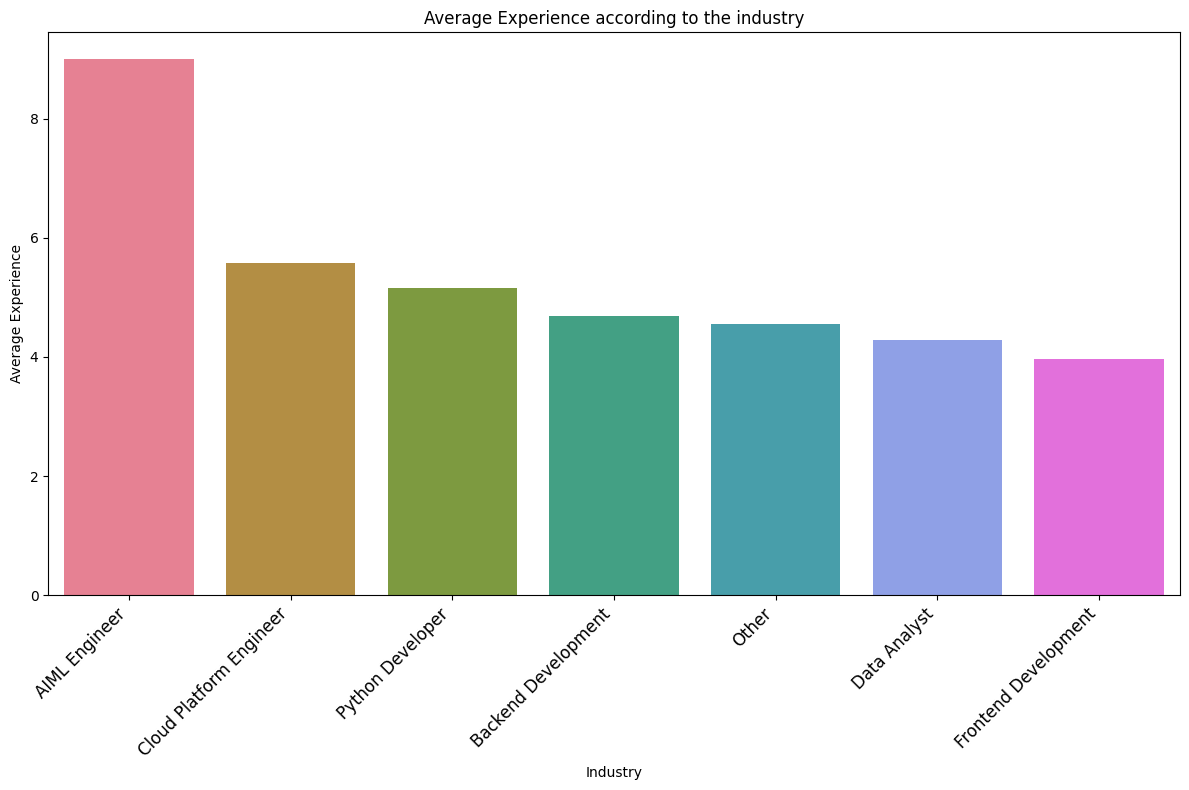

In [84]:
plt.figure(figsize=(12,8))
sns.barplot(
    x='industry',
    y='avg_exp',
    data=industry_exp_df,
    palette='husl'
    )
plt.xlabel("Industry")
plt.ylabel("Average Experience")
plt.title("Average Experience according to the industry")
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.tight_layout()
plt.show()